# Exercise 6
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-06-02: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')
from pprint import pprint
from scipy.special import factorial

# Notebook graphics settings: 
%config InlineBackend.figure_format = 'svg'     # inline vector graphics
#%config InlineBackend.figure_format = 'png'    # inline vector graphics
#%config InlineBackend.figure_format = 'retina' # medium resolution png:s
plt.rcParams['figure.dpi'] = 200                # custom dpi setting png

## Task 1: Poisson latent variable models

In [2]:
# Import and extract the matrices and vectors.
import scipy.io
mat = scipy.io.loadmat('ex6file.mat')

print(mat.keys())
A     = mat['A']
B     = mat['B']
gamma = mat['Gamma']
sigma = mat['Sigma']
mu0   = mat['mu0']
n0    = mat['n0']
u     = mat['u']

mu0 = mu0.flatten()
n0 = n0.flatten()

dict_keys(['__header__', '__version__', '__globals__', 'A', 'B', 'Gamma', 'Sigma', 'mu0', 'n0', 'u'])


(2, 100)


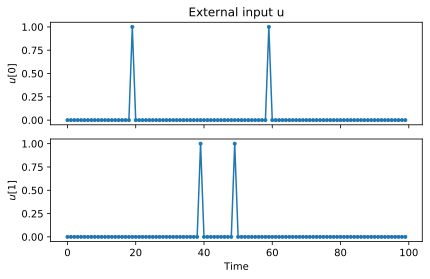

In [3]:
print(u.shape)

# Plotting the external inputs u.
fig, ax = plt.subplots(u.shape[0], 1, sharex=True)
ax = ax.flatten()
for i in range(u.shape[0]):
    ax[i].plot(u[i], '.-')
    ax[i].set_ylabel(f'$u[{i}]$')
ax[-1].set_xlabel('Time')
ax[0].set_title('External input u')
fig.tight_layout()
plt.show()

# Transpose for easier python notation
u = u.T

In [4]:
# Generate a Poisson latent time series model.
T  = 100
dt = 1
N, M = gamma.shape # shape=(nr_observations, nr_latent)

# Pre-allocations
z = np.zeros((T, M))
c = np.zeros((T, N))
lam = np.zeros_like(c)

# Generate process noise 
eps = np.random.multivariate_normal(np.zeros(M), sigma, size=T)

# Set the initial conditions
z[0]   = np.random.multivariate_normal(mu0, sigma)
lam[0] = np.exp(np.log(n0) + gamma @ z[0])
c[0]   = np.random.poisson(lam[0]*dt)

# Generate the time series
for t in range(1, T):
    z[t]   = A @ z[t-1] + B @ u[t] + eps[t]
    lam[t] = np.exp(np.log(n0) + gamma @ z[t])
    c[t]   = np.random.poisson(lam[t]*dt)

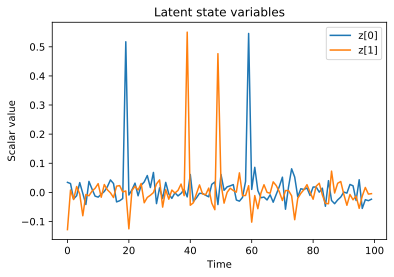

In [5]:
# Plotting the latent state variables z.
for i in range(M):
    plt.plot(z[:, i], label=f'z[{i}]')
plt.ylabel('Scalar value')
plt.xlabel('Time')
plt.title('Latent state variables')
plt.legend()
plt.show()

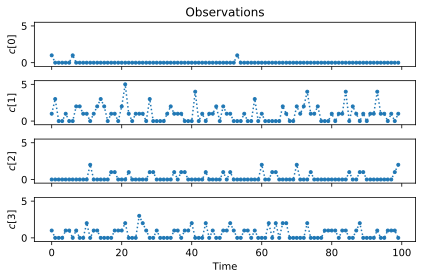

In [6]:
# Plotting the observations c.
fig, ax = plt.subplots(N, 1, sharex=True)
ax = ax.flatten()
for i in range(N):
    ax[i].plot(c[:, i], '.:')
    ax[i].set_ylabel(f'$c[{i}]$')
    ax[i].set_ylim([-0.5, np.max(c)+0.5])
ax[-1].set_xlabel('Time')
ax[0].set_title('Observations')
fig.tight_layout()
plt.show()

In [7]:
# Calculate the joint data log-likelihood of the generated Poisson series.
from scipy.special import factorial

sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)

logL_initcond = -0.5*M*np.log(2*np.pi) - 0.5*np.log(sigma_det) - 0.5*(z[0]-mu0).T @ sigma_inv @ (z[0]-mu0)
logL_trsmodel = -0.5*M*(T-1)*np.log(2*np.pi) - 0.5*(T-1)*np.log(sigma_det) - 0.5*np.trace(eps[1:] @ sigma_inv @ eps[1:].T)
logL_obsmodel = np.sum(c*np.log(lam*dt) - np.log(factorial(c)) - lam*dt)
logL = logL_initcond + logL_trsmodel + logL_obsmodel
print(f"Joint data log-likelihood of the generated Poisson series: {logL:.6}")

Joint data log-likelihood of the generated Poisson series: 114.436


## Task 2: Fixed points, stability and bifurcations.

In [8]:
def nonlinear_map(x, w, theta):
    return w * sigmoid(x) + theta

def sigmoid(x):
    """
    Numerically stable sigmoid function.
    """
    out = np.zeros_like(x)
    mask = x >= 0
    out[mask]  = 1 / (1 + np.exp(-x[mask]))                # x positive
    out[~mask] = np.exp(x[~mask]) / (1 + np.exp(x[~mask])) # x negative
    return out

Fixpoint approximately at x = 4.41441


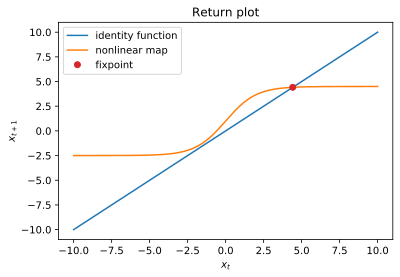

In [9]:
# Generate a return plot for the specified parameters.
w = 7
theta = -2.5 
x = np.linspace(-10, 10, 1000)
x_out = nonlinear_map(x, w, theta)

# Find the (singular) pixpoint
x_fix = x[np.argmin((x_out - x)**2)]
print(f'Fixpoint approximately at x = {x_fix:.6}')

# Visualize
plt.plot(x, x, label='identity function')
plt.plot(x, x_out, label='nonlinear map')
plt.plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint')
plt.xlabel('$x_t$')
plt.ylabel('$x_{t+1}$')
plt.title('Return plot')
plt.legend()
plt.show()

Since the  slope at the fixpoint for the nonlinear map is less than one in absolute value, the fixpoint is stable. We can easily check this by first calculating the derivative of the nonlinear map, as per
\begin{equation}
    \frac{\partial x_{t+1}}{\partial x_t} = \frac{\partial f(x_{t}, w, \theta)}{\partial x_t} = \frac{\partial}{\partial x_t} \left(w \sigma(x_t) + \theta \right) = w\frac{\partial \sigma(x_t)}{\partial x_t} = w\sigma(x_t) (1-\sigma(x_t)).
\end{equation}
If we then evaluate the gradient at the fixpoint, we approximately get:

In [10]:
def grad_nonlinear_map(x, w):
    return w * sigmoid(x) * (1-sigmoid(x))

grad_fixpoint = grad_nonlinear_map(x_fix, w)
print(f'Slope at fixpoint = {grad_fixpoint:.5}')

Slope at fixpoint = 0.082698


Which is way less than unity in absolute value, and thus the fixpoint is stable. Also, to get a feeling for the behaviour of the nonlinear map for different initial condiations, one can generate cobweb diagrams to explore the dynamics.

In [11]:
def cobweb(x, y_min):
    T = len(x)
    x_out = np.zeros(2*T-1)
    y_out = np.zeros(2*T-1)
    x_out[0], y_out[0] = x[0], y_min 
    for i in range(1, T):
        x_out[2*i-1], y_out[2*i-1] = x[i-1], x[i] 
        x_out[2*i], y_out[2*i] = x[i], x[i]
    return x_out, y_out

In [12]:
def iterate_time(x0, T, w, theta):
    x = np.zeros(T)
    x[0] = x0
    for t in range(1, T):
        x[t] = nonlinear_map(x[t-1], w, theta)
    return x

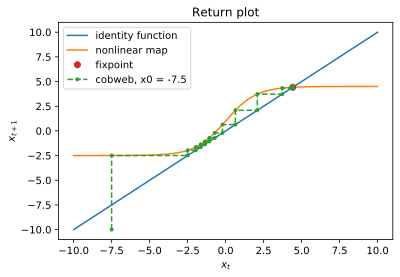

In [13]:
# Generate a time series given the starting position x0, and its cobweb diagram.
xt = iterate_time(x0=-7.5, T=30, w=7, theta=-2.5)
x_cobw, y_cobw = cobweb(xt, y_min=-10)

# Visualize
plt.plot(x, x, label='identity function')
plt.plot(x, x_out, label='nonlinear map')
plt.plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint')
plt.plot(x_cobw, y_cobw, '.--', label=f'cobweb, x0 = {x_cobw[0]}')

plt.xlabel('$x_t$')
plt.ylabel('$x_{t+1}$')
plt.title('Return plot')
plt.legend()
plt.show()

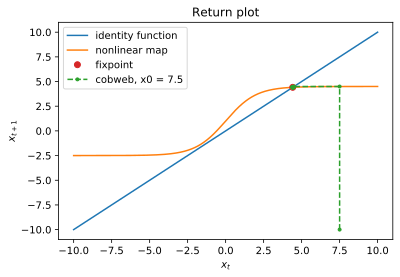

In [14]:
# Generate a time series given the starting position x0, and its cobweb diagram.
xt = iterate_time(x0=7.5, T=30, w=7, theta=-2.5)
x_cobw, y_cobw = cobweb(xt, y_min=-10)

# Visualize
plt.plot(x, x, label='identity function')
plt.plot(x, x_out, label='nonlinear map')
plt.plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint')
plt.plot(x_cobw, y_cobw, '.--', label=f'cobweb, x0 = {x_cobw[0]}')

plt.xlabel('$x_t$')
plt.ylabel('$x_{t+1}$')
plt.title('Return plot')
plt.legend()
plt.show()

#### Bifurcation diagram, $w = 7$, $\theta \in [-10, 0]$:

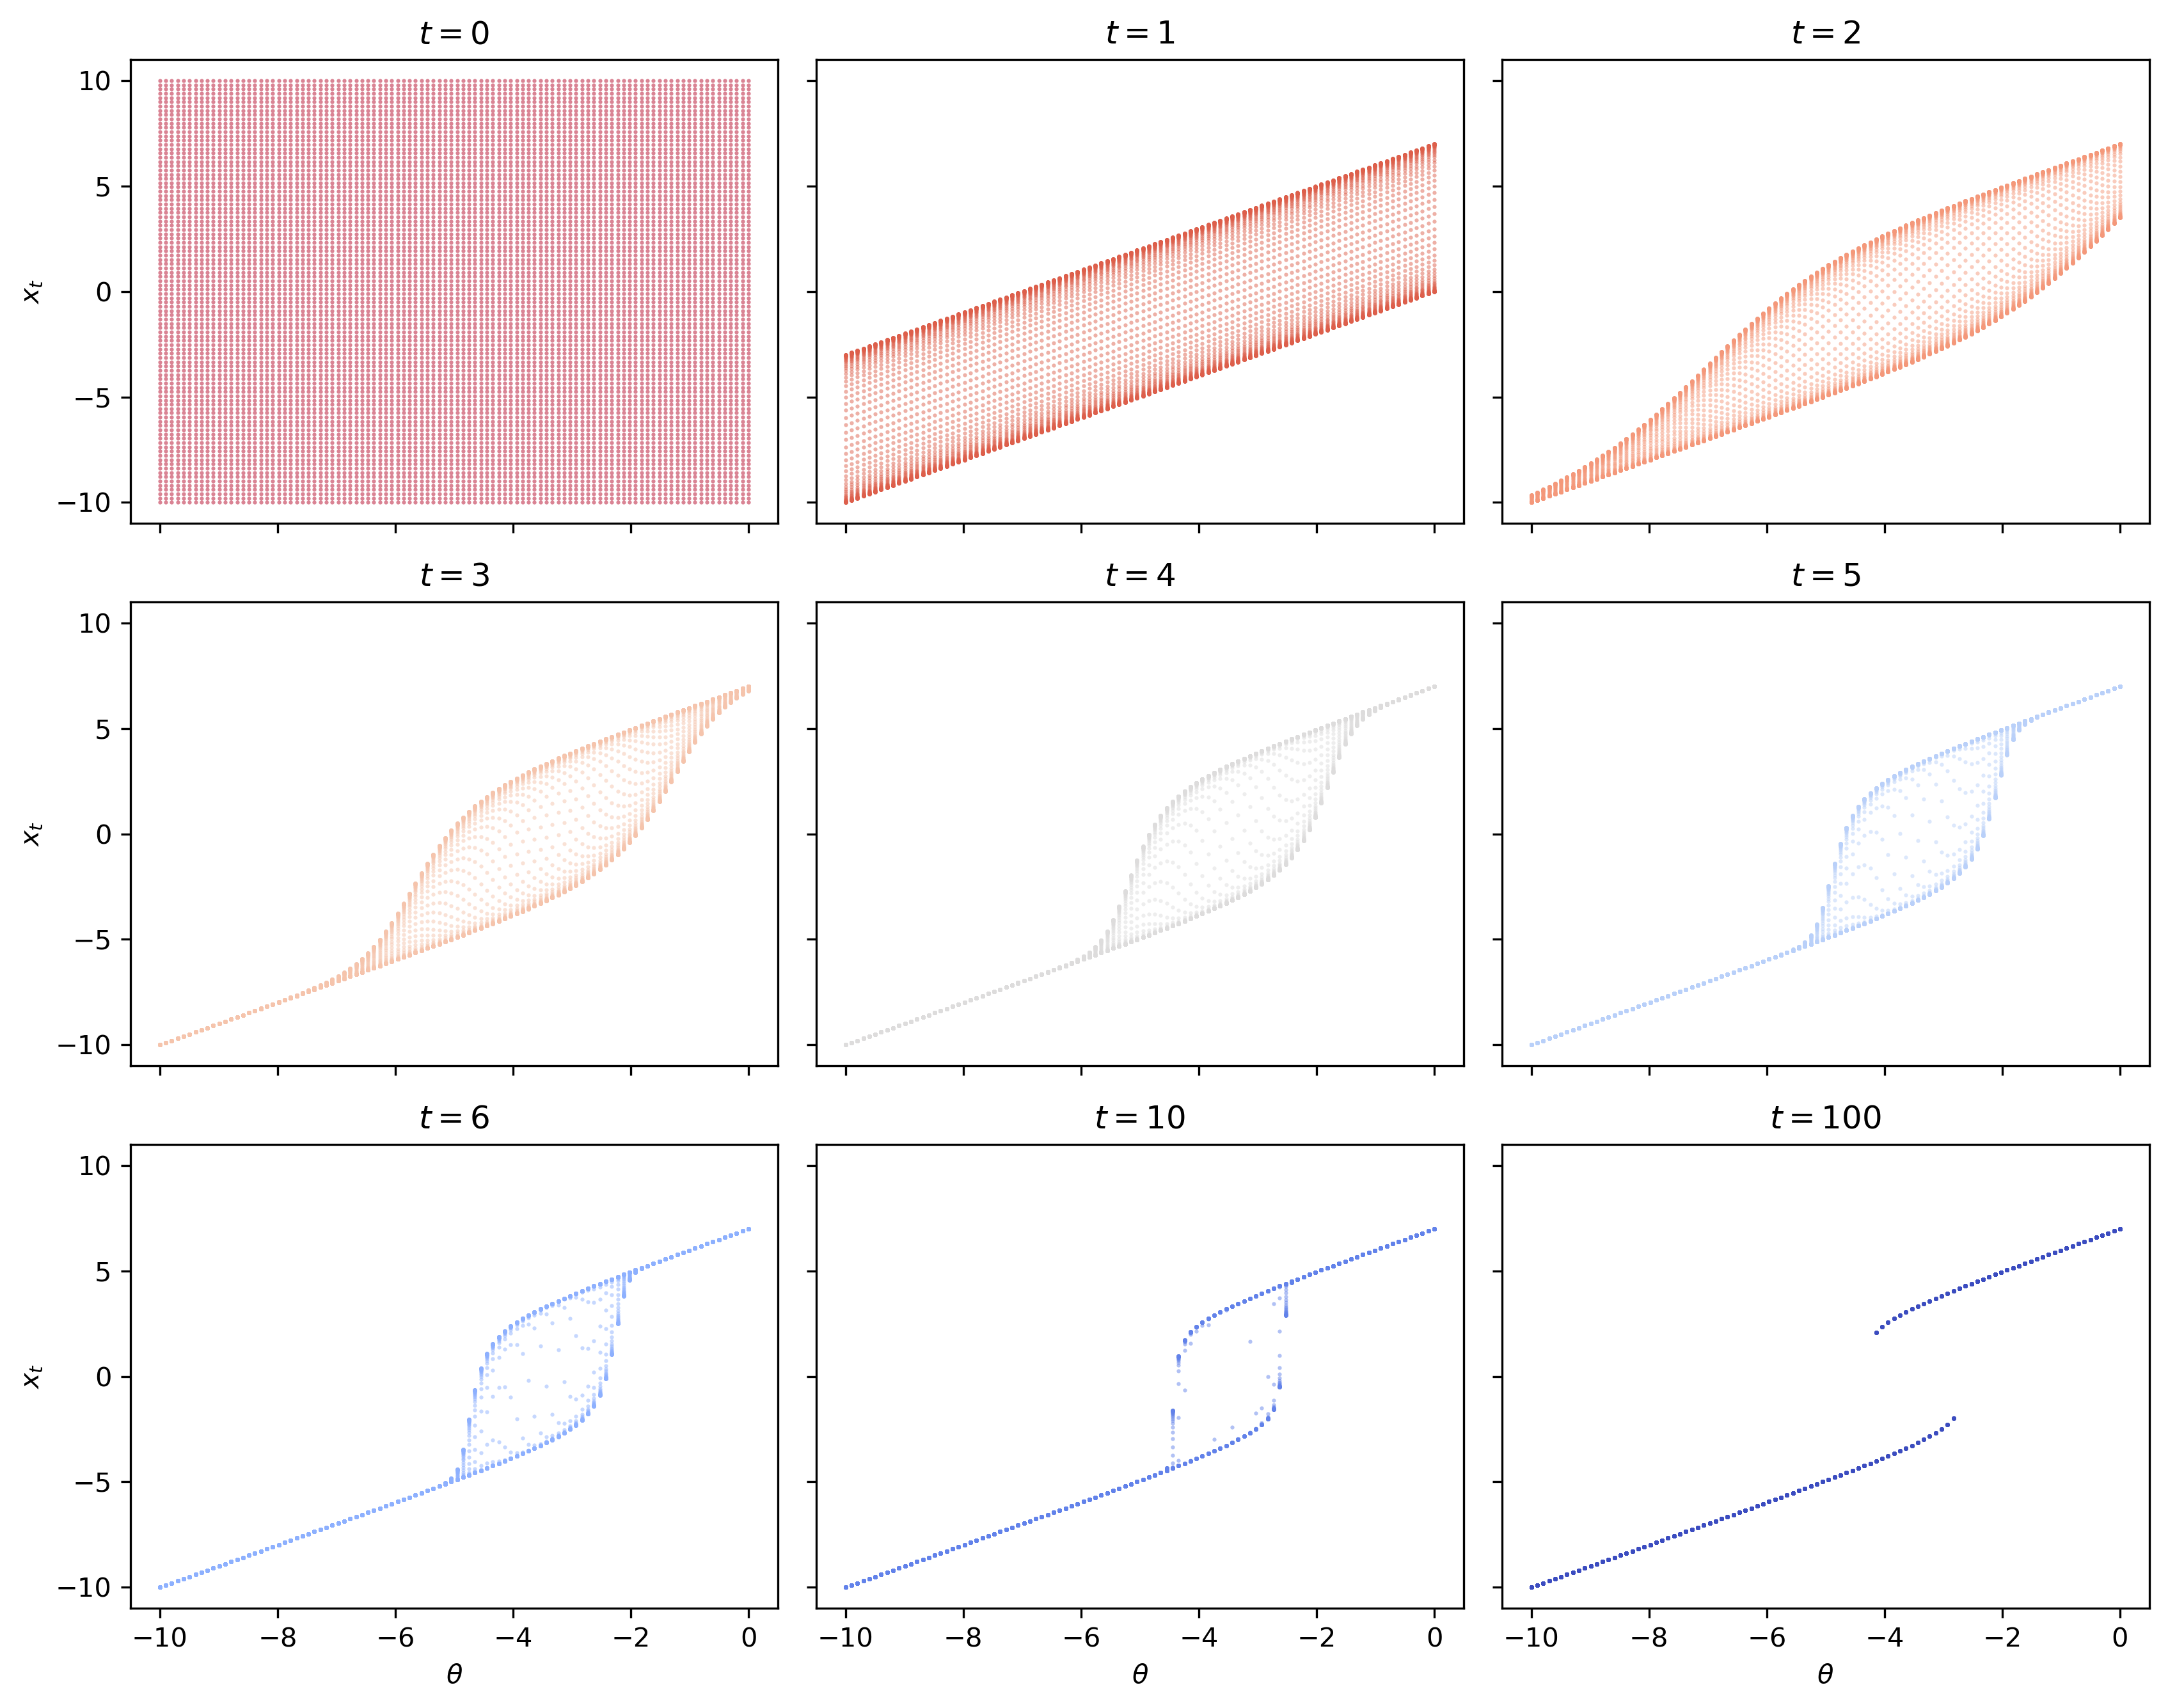

In [15]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 300 

plot_iterations = [0, 1, 2, 3, 4, 5, 6, 10, 100] # which iterations to plot
iterations = max(plot_iterations)                # max nr of iterations in time

# Parameters of the nonlinear map.
w = 7
theta = np.linspace(-10, 0, 100) 
                 
# For each initial condition, iterate in time for the range of thetas, plotting the state progression.

# Set sequential colormap
cmap = 'coolwarm'
colors = getattr(plt.cm, cmap)(np.linspace(1, 0, len(plot_iterations)))

# Create subplot
nx, ny = 3, 3
fig, ax = plt.subplots(ny, nx, figsize=(3.8*nx, 3*ny), sharex=True, sharey=True)
ax = ax.flatten()

# Initial conditions for x.
x = np.linspace(-10, 10, 100)
x = np.tile(x,(len(theta),1)) # stack as matrix 

# Iterating x in time, plot at the selected iterations.
i = 0 
for t in range(iterations+1):
    if t != 0:
        x = nonlinear_map(x, w, theta.reshape(-1, 1))
    if t in plot_iterations:
        ax[i].plot(theta.reshape(-1, 1), x, '.', alpha=0.5, color=colors[i], markersize=1)
        ax[i].set_title(f'$t = {t}$')
        if i >= (nx-1)*ny:
            ax[i].set_xlabel('$\\theta$')
        if i%nx == 0:
            ax[i].set_ylabel('$x_t$')
        i += 1    
plt.tight_layout()
plt.show()

There seems to be a single stable fixpoint for most of the interval of $\theta$, but inbetween $\theta \approx -2.7$ and $\theta \approx -4.2$, there seems to be two stable fixpoints.

To uncover what's going on, let's generate return plots for various values of $\theta$, complete with the fixpoints in each return map.

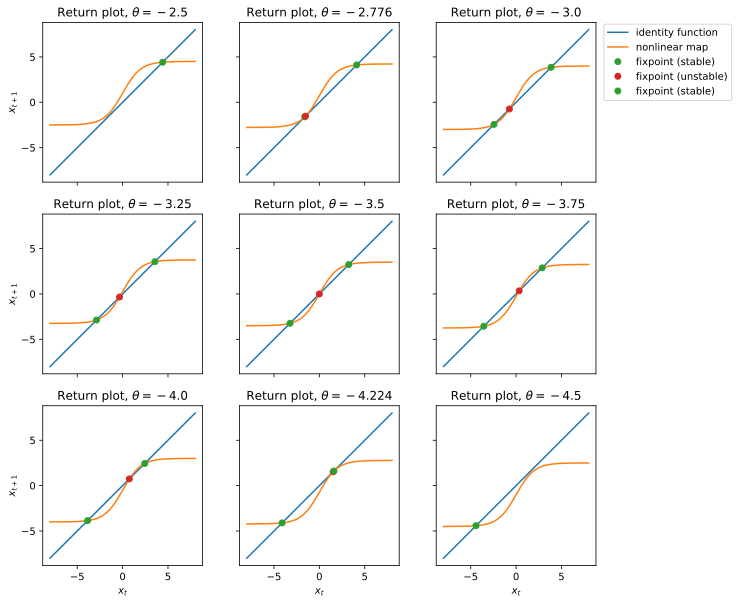

In [17]:
%config InlineBackend.figure_format = 'svg'
from scipy.optimize import fsolve

tol = 1e-6 # max. allowed residual for fix points.

# Parameters for which to generate return plots. 
w = 7
theta_list = np.array([-2.5,  -2.776, -3., -3.25, -3.5, -3.75, -4., -4.224, -4.5])

# Create subplot
nx, ny = (3, 3)
fig, ax = plt.subplots(nx, ny, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()

x = np.linspace(-8, 8, 1000)
for i, theta in enumerate(theta_list):
    # Generate output for 1st order return plot.
    x_out = nonlinear_map(x, w, theta)

    # Find all fixpoints.
    f      = lambda x: nonlinear_map(x, w, theta) - x 
    fprime = lambda x: grad_nonlinear_map(x, w) - 1
    x_init  = np.linspace(-10, 10)  # initial root guesses
    x_roots = np.zeros_like(x_init) # preallocation
    for j, x0 in enumerate(x_init): 
        x_roots[j] = fsolve(f, x0, fprime=fprime) # solve for the root numerically
    residuals   = f(x_roots)
    valid_roots = x_roots[np.abs(residuals) < tol] # filter out roots with high residuals    
    unique_fixpoints = np.unique(valid_roots.round(decimals=5)) # get unique roots
    
    # Visualize the return map, and the fixpoints.
    ax[i].plot(x, x, label='identity function')
    ax[i].plot(x, x_out, label='nonlinear map')
    for j, x_fix in enumerate(unique_fixpoints):
        grad_fix = grad_nonlinear_map(x_fix, w)
        if np.abs(grad_fix) < 1:
            ax[i].plot(x_fix, x_fix, 'o', c='tab:green', label='fixpoint (stable)')
        else:
            ax[i].plot(x_fix, x_fix, 'o', c='tab:red', label='fixpoint (unstable)')
    if i >= (nx-1)*ny:
        ax[i].set_xlabel('$x_t$')
    if i%nx == 0:
        ax[i].set_ylabel('$x_{t+1}$')
    ax[i].set_title(f'Return plot, $\\theta = {theta}$')
    ax[i].set_aspect('equal')
ax[len(theta_list)//2].legend(loc='center left', bbox_to_anchor=(2.25, 1.95))
plt.show()

Here one can see that as we decrease $\theta$, the nonlinear map eventually starts to intersect the identity function at a secondary position, creating two new fixpoints: one stable and one unstable fixpoint. As $\theta$ is decreased even further, eventually the nonlinear map stops intersecting the unit function at two or more places, and the system returns to having just a single stable fixpoint.

## Task 3: Nonlinear systems, oscillations and chaos.

To find the fixpoint of the 'Ricker map', i.e.
\begin{equation}
    x_{t+1} = r x_t e^{-x_t}
\end{equation}
for $x_t, r \in \mathbb{R}$, we let $x_{t+1} = x_t$ and solve for $x$, as per
\begin{align}
   x_{t} &= r x_t e^{-x_t}\\
    \Longrightarrow 0 &= r x_t e^{-x_t} - x_t\\
    &= x_t \left( re^{-x_t} -1 \right).
\end{align}
Thus we have our first fixpoint at $x^*_1 = 0$, or 
\begin{align}
    0 &= re^{-x_t} - 1\\
    \Longrightarrow x &= \log(r),
\end{align}
which gives us our second fixpoint as $x^*_2 = \log(r)$, which will coincide with the first fixpoint when $r=1$.

In [18]:
def ricker_map(x, r):
    return r * x * np.exp(-x)

In [19]:
def ricker_diff(x, r):
    return -r * np.exp(-x) * (x-1)

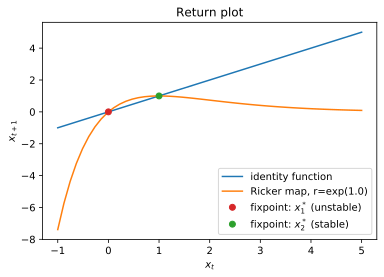

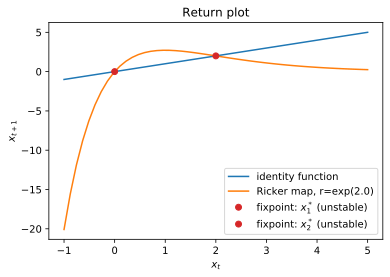

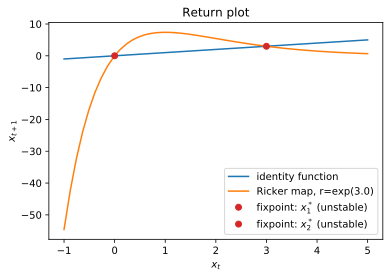

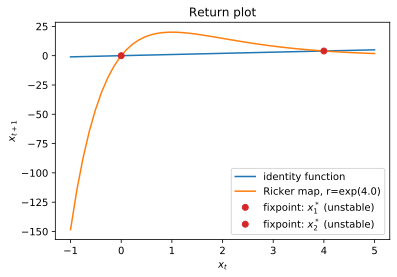

In [20]:
# Exploring the Ricker map
r_arr = np.exp([1, 2, 3, 4])
for r in r_arr:
    x = np.linspace(-1, 5)
    x_out = ricker_map(x, r)
    x_fixpoints = np.array([0, np.log(r)])
    fix_diff = ricker_diff(x_fixpoints, r)

    plt.plot(x, x, label='identity function')
    plt.plot(x, x_out, label=f'Ricker map, r=exp({np.log(r)})')
    for i, x_fix in enumerate(x_fixpoints):
        if np.abs(fix_diff[i]) < 1:
            plt.plot(x_fix, x_fix, 'o', c='tab:green', label=f'fixpoint: $x^*_{i+1}$ (stable)')
        else:
            plt.plot(x_fix, x_fix, 'o', c='tab:red', label=f'fixpoint: $x^*_{i+1}$ (unstable)')
    plt.xlabel('$x_t$')
    plt.ylabel('$x_{t+1}$')
    plt.title('Return plot')
    plt.legend()
    plt.show()

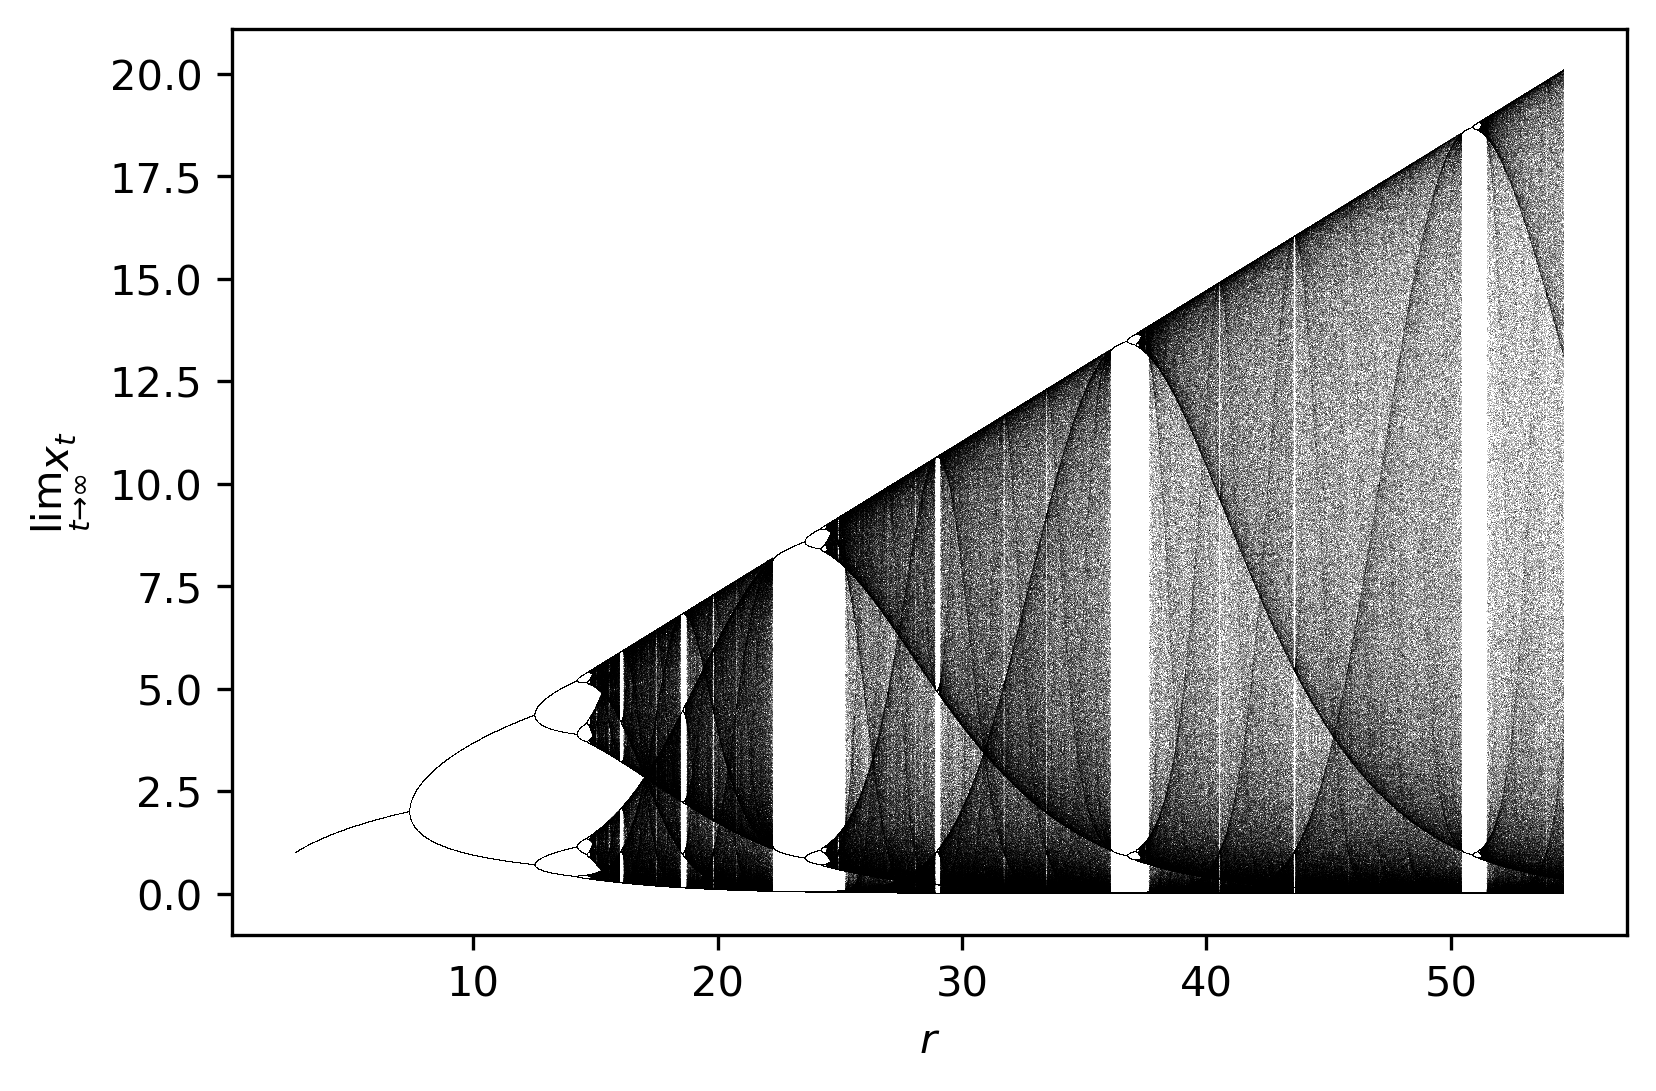

In [21]:
%config InlineBackend.figure_format = 'png'

r = np.linspace(np.exp(1), np.exp(4), 10000) 
iterations = 1000                
display_last = 100               

x0_range = np.linspace(0.1, 5, 5)
for x0 in x0_range: 
    x = np.ones_like(r) * x0
    for i in range(iterations):
        x = ricker_map(x, r)
        if i >= (iterations - display_last):
            plt.plot(r, x, ',k', alpha=0.25)
            
plt.xlabel('$r$')
plt.ylabel('$\lim_{t \\to \infty} x_t$')
plt.show()

In the bifurcation diagram above, we can see how the system becomes chaotic as the value of $r$ increases. A single stable fixpoint bifurcates into a stable limit-cycle of period 2, which then doubles again and again into a cascade of period doublings which quickly takes us into the chaotic regime.